# Лабораторная работа №6
Lidar. Tree Classification.

In [1]:
# Loading extension for reloading editable packages (pip install -e .)
%load_ext autoreload

In [2]:
!pip freeze

absl-py==1.4.0
aiohttp==3.9.5
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.15.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.5.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.2
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.1
cryptography==42.0.7
cuda-python==12.2.1
cudf-cu12 @ https:

Вариант: 14 (чётный => данные h5.v**2**)

In [3]:
import pickle
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from numpy.typing import ArrayLike, NDArray
from PIL import Image
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Tree Classification with Lidar
### Загрузка набора данных

Подготовка модулей и переменных для работы с файлами.

In [5]:
import os  # noqa
import shutil  # noqa
import urllib  # noqa
from pathlib import Path  # noqa

data_path = Path("data")
data_path.mkdir(exist_ok=True)

external_data_path = data_path / "external"
interim_data_path = data_path / "interim"
processed_data_path = data_path / "processed"

external_data_path.mkdir(exist_ok=True)
interim_data_path.mkdir(exist_ok=True)
processed_data_path.mkdir(exist_ok=True)

Подготовка модулей и переменных для загрузки данных.

In [6]:
url = "https://github.com/iu5git/Deep-learning/raw/main/datasets/lidar/v2.h5"
dataset_filename = "v2.h5"

external_data_path.mkdir(exist_ok=True)

file_path = external_data_path / dataset_filename

Загрузка набора данных.
Каждая точка одного облака точек содержит информацию о 3 различных координатах,
данный формат удобен для хранения и работы с таким большим объемом данных.

In [7]:
if not os.path.isfile(file_path):
    print(urllib.request.urlretrieve(url, file_path))

(PosixPath('data/external/v2.h5'), <http.client.HTTPMessage object at 0x7eabfc23aec0>)


### Чтение тренировочной и тестовой выборки

In [8]:
import h5py

h5f = h5py.File(file_path,'r') # файл по вашему варианту
X = h5f.get('dataset_X')[:]
Y = h5f.get('dataset_Y').asstr()[:]
h5f.close()

In [9]:
NUM_POINTS = 4096
BATCH_SIZE = 64

unique_classes = np.unique(Y)
CLASSES = {i: tree_class for i, tree_class in enumerate(unique_classes)}
CLASSES

{0: 'Береза', 1: 'Ель', 2: 'Сосна'}

In [10]:
Y = np.array([list(CLASSES.values()).index(y) for y in Y])
indexes = []
[indexes.append(y) for y in list(Y) if y not in indexes]
indexes.sort()
CLASS_MAP = {i: CLASSES[k] for (k, i) in (zip(indexes, range(len(indexes))))}

#кол-во классов по вашему варианту
NUM_CLASSES = len(CLASS_MAP)

for (k, i) in (zip(indexes, range(len(indexes)))):
  Y[Y == k] = i

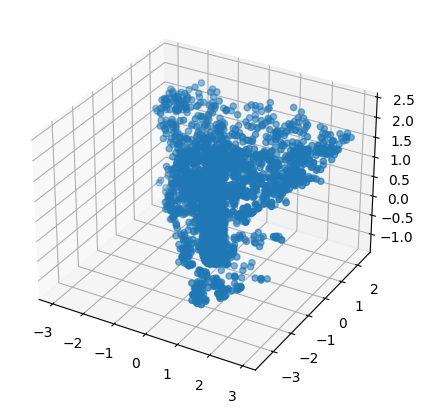

In [11]:
points = X[50]

fig = plt.figure(figsize=(5, 5))
# 111 = size, size, number of cell
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
plt.show()

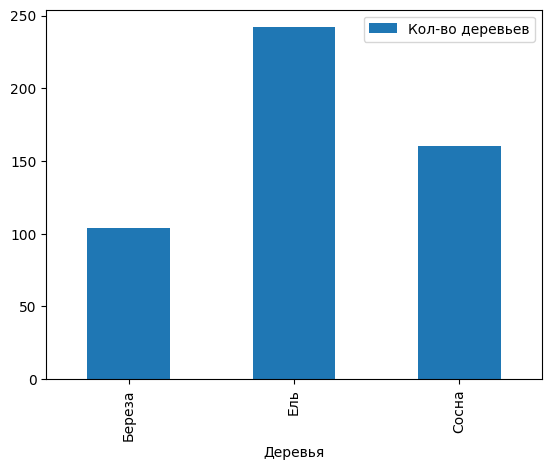

In [12]:
import pandas as pd

data = {'Кол-во деревьев': list(pd.value_counts(Y).sort_index()),
        'Деревья': list(CLASS_MAP.values())}
df = pd.DataFrame(data).set_index('Деревья')
ax = df.plot.bar()

### Разбиение выборки на тренировочную и тестовую

In [13]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5).split(X, Y)

for train_index, test_index in skf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

X_augment = []
y_augment = []

for i in range(4):
    point_select = []
    for x in X_train:
        idx = np.random.choice(NUM_POINTS, size=NUM_POINTS, replace=True)
        point_select.append(x[idx])
    point_select = np.array(point_select)
    point_select = point_select + np.random.normal(0, 0.005, point_select.shape)
    X_augment.append(point_select)
    y_augment.append(y_train)

X_augment = np.array(X_augment)
y_augment = np.array(y_augment)
X_augment = np.reshape(X_augment,(X_augment.shape[0] * X_augment.shape[1], NUM_POINTS, 3))
y_augment = np.reshape(y_augment,(-1))

In [14]:
import tensorflow as tf

tf.random.set_seed(42)

train_dataset = tf.data.Dataset.from_tensor_slices((X_augment, y_augment))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(len(X_augment)).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE)

### Построение модели
Каждый сверточный и полносвязный слой (не включая конечных слоев) состоит из Convolution / Dense -> Batch Normalization -> ReLU Activation.

In [15]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

PointNet состоит из двух основных компонентов:
основная сеть MLP (многослойный перцептрон) и трансформаторная сеть T-net.

In [16]:
from tensorflow import keras

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

Определим общую функцию для построения слоев T-net.

In [17]:
def tnet(inputs, num_features):

    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)

    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [18]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4096, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 4096, 32)             128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 4096, 32)             128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 4096, 32)             0         ['batch_normalization[0

### Обучение модели

In [19]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
26/26 [==============================] - 29s 608ms/step - loss: 5.1083 - sparse_categorical_accuracy: 0.3562 - val_loss: 3.9593 - val_sparse_categorical_accuracy: 0.4851
Epoch 2/10
26/26 [==============================] - 14s 535ms/step - loss: 4.1732 - sparse_categorical_accuracy: 0.5364 - val_loss: 3.5011 - val_sparse_categorical_accuracy: 0.5842
Epoch 3/10
26/26 [==============================] - 14s 536ms/step - loss: 3.7027 - sparse_categorical_accuracy: 0.6444 - val_loss: 3.0851 - val_sparse_categorical_accuracy: 0.6337
Epoch 4/10
26/26 [==============================] - 14s 542ms/step - loss: 3.3917 - sparse_categorical_accuracy: 0.7117 - val_loss: 3.0481 - val_sparse_categorical_accuracy: 0.5941
Epoch 5/10
26/26 [==============================] - 14s 541ms/step - loss: 3.1763 - sparse_categorical_accuracy: 0.7654 - val_loss: 3.1674 - val_sparse_categorical_accuracy: 0.6040
Epoch 6/10
26/26 [==============================] - 14s 541ms/step - loss: 3.0224 - sparse_cate

### Визуализация

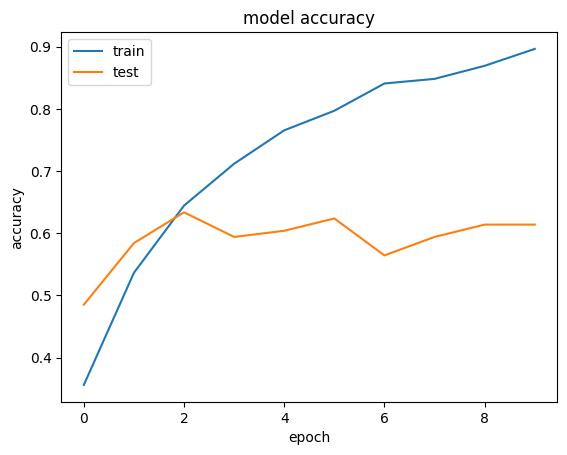

In [20]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

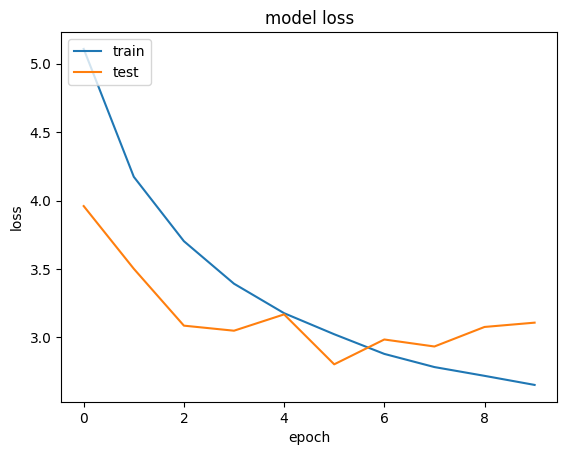

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 817ms/step


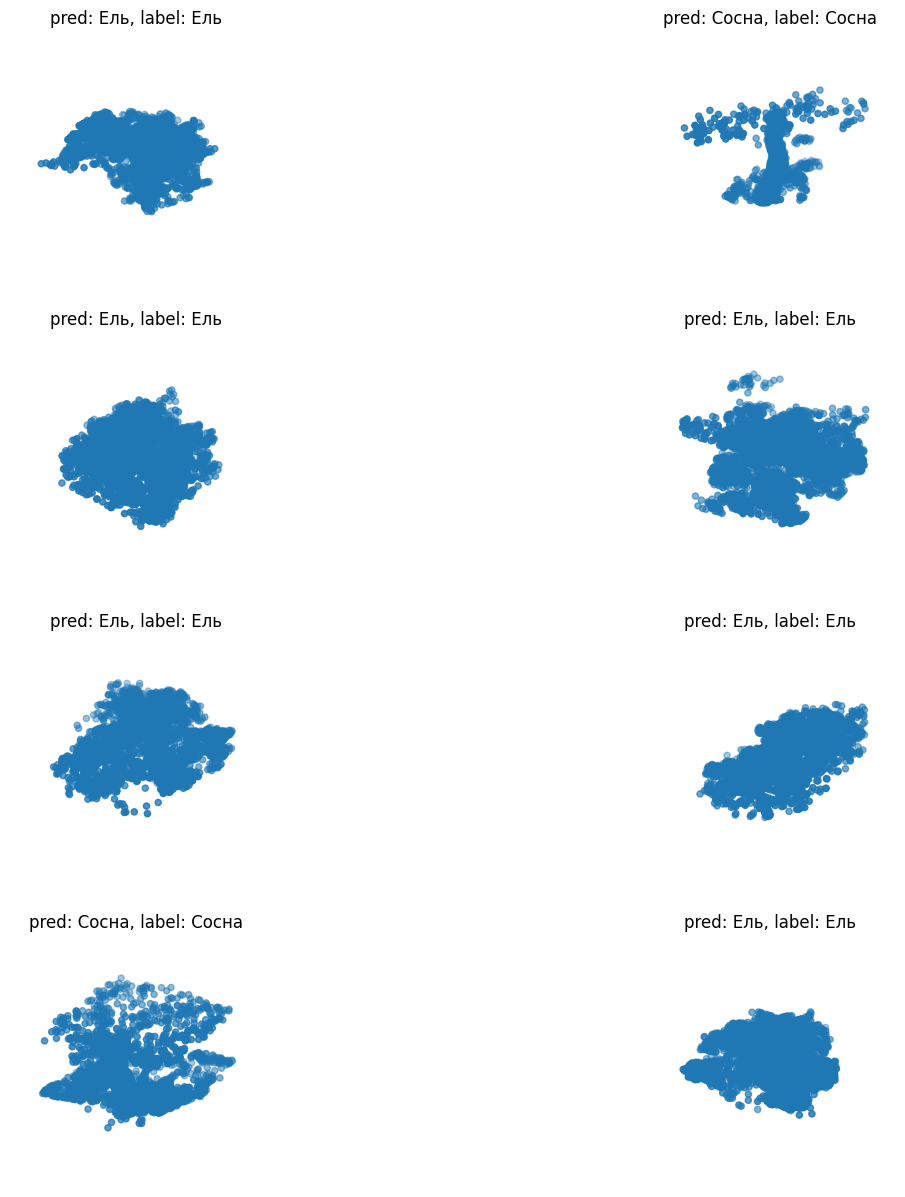

In [22]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

fig = plt.figure(figsize=(15, 15))
for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [23]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
from sklearn.metrics import confusion_matrix

data = test_dataset.take(1)
points, labels = list(data)[0]
points = points[:, ...]
labels = labels[:, ...]

preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

cm = confusion_matrix(y_true=labels, y_pred=preds)

2/2 [==============================] - 0s 39ms/step


Confusion matrix, without normalization
[[ 5  6  2]
 [ 4 22  1]
 [10  5  9]]


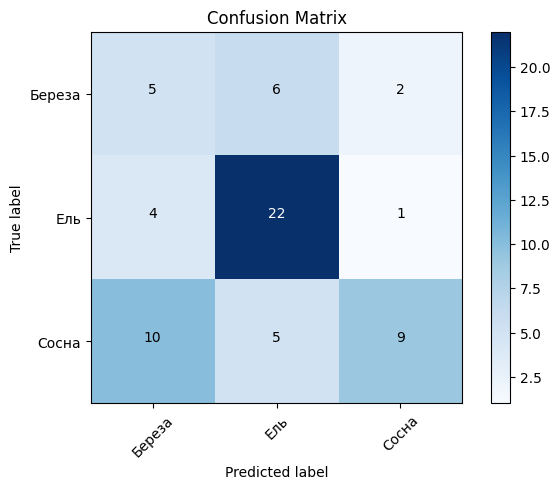

In [27]:
plot_confusion_matrix(cm=cm, classes=CLASS_MAP.values(), title='Confusion Matrix')